In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/test.csv
/kaggle/input/bike-sharing-demand/train.csv


In [2]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values) :
    predicted_values = np.array(predicted_values)
    actual_values - np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values+1)
    
    diff = log_predict - log_actual
    diff = np.square(diff)
    mean_diff = diff.mean()
    score = np.sqrt(mean_diff)
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv", parse_dates = ['datetime'])
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv", parse_dates = ['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## DataFields
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

# Feature Engineering

In [8]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [9]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

(array([1.313e+03, 4.083e+03, 2.827e+03, 1.540e+03, 6.960e+02, 2.800e+02,
        1.070e+02, 3.100e+01, 6.000e+00, 3.000e+00]),
 array([ 0.     ,  5.69969, 11.39938, 17.09907, 22.79876, 28.49845,
        34.19814, 39.89783, 45.59752, 51.29721, 56.9969 ]),
 <a list of 10 Patch objects>)

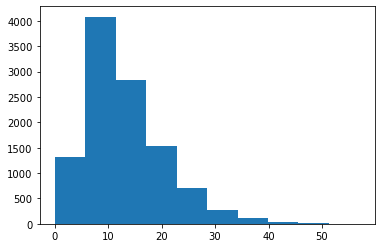

In [10]:
plt.hist(train['windspeed'])

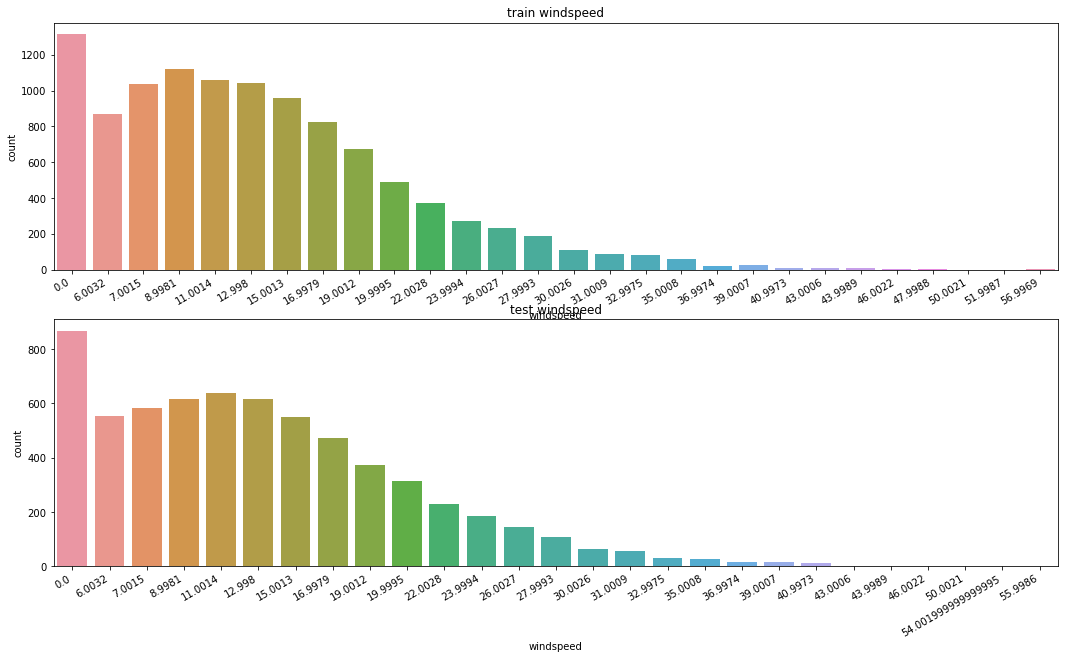

In [11]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [12]:
trainwind0 = train.loc[train['windspeed']==0]
trainwindnot0 = train.loc[train['windspeed'] != 0]
trainwind0.shape, trainwindnot0.shape

((1313, 19), (9573, 19))

In [13]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    dataWind0 = data.loc[data['windspeed']==0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # Selecting the features that will predict windspeed
    wCol = ['season', 'weather','humidity','month','temp','year','atemp']
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype(str)
    
    rfmodel_wind = RandomForestClassifier()
    rfmodel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])

    
    wind0Values = rfmodel_wind.predict(X=dataWind0[wCol])
    
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    predictWind0['windspeed'] = wind0Values
    
    data = predictWindNot0.append(predictWind0)
    
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

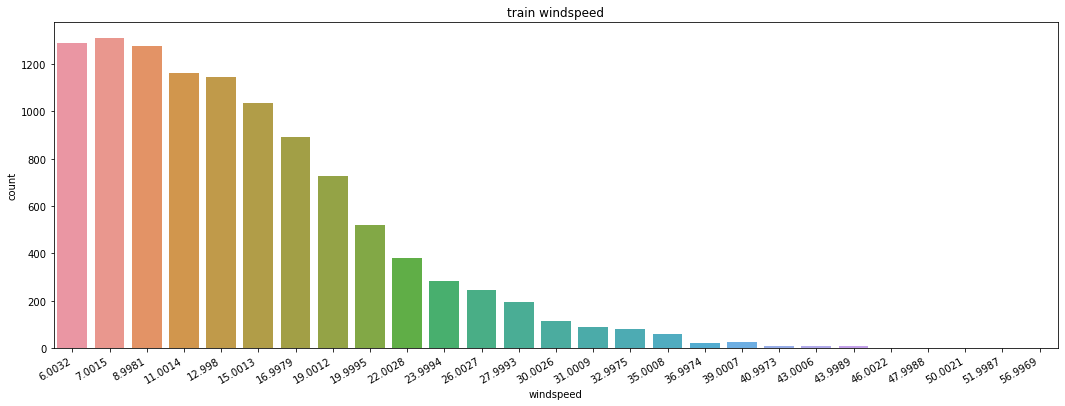

In [14]:
train = predict_windspeed(train)
test = predict_windspeed(test)

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

# Feature Selection
- 신호와 잡음을 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [15]:
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]
for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [16]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [17]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [26]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
2,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1
3,1,1,9.84,11.365,60,15.0013,2011,5,3,0,1
4,1,1,9.02,10.605,60,15.0013,2011,6,3,0,1


In [18]:
label_name='count'
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [19]:
y_train

0          1
1         36
2         56
3         84
4         94
        ... 
10881    232
10882    211
10883    662
10884    132
10885     41
Name: count, Length: 10886, dtype: int64

# Score
정밀도 : Positive 예측한 대상 중에서 예측과 실제 값이 Positive로 일치한 데이터의 비율
    - Positive예측 성능을 더욱 정밀하게 측정하기 위한 평가지표(양성 예측도)
재현율 : Positive 실제 값 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
    - 민감도, True Positive Rate

In [20]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,0,0,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,0,0,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011,1,1,12,0,0,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011,1,1,13,0,0,5


# RandomForest

In [21]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
model = RandomForestRegressor(n_estimators=100,
                             n_jobs=-1,
                             random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [23]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score=score.mean()

#0에 근접할수록 좋은 데이터
print("Score = {0:.5f}".format(score))

CPU times: user 3.74 s, sys: 983 ms, total: 4.72 s
Wall time: 16.7 s
Score = 0.33066


In [24]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [28]:
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.68,   3.53,   3.11,   6.19,  37.97, 104.12, 236.63, 137.17,
        62.76,  62.7 ])

Text(0.5, 1.0, 'test')

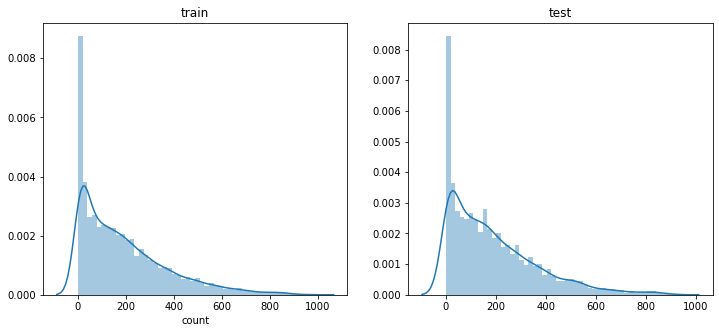

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set_title('test')

In [31]:
submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')
submission

submission['count'] = predictions
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.68
1,2011-01-20 01:00:00,3.53
2,2011-01-20 02:00:00,3.11
3,2011-01-20 03:00:00,6.19
4,2011-01-20 04:00:00,37.97


In [33]:
submission.to_csv("/kaggle/working/Score_{0:.5f}_Submission.csv".format(score), index=False)